# Maven Roasters: Coffee Shop Sales & Revenue Data

Understanding sales trends at multiple timescales (for example, hourly, daily and weekly) and for different product is crucial when operating stores. These assist with planning operational costs, refilling stock and setting prices. 

In this analysis, we investigate the revenue generated by sales across three groupings; store location, product category and product. We also look at the trend in revenue over a typical day, week, and throughout the 6months the data set covers. A revenue in a 'typical' day and week is calculated through an average. 

The daily, weekly and monthly revenue shows a clear difference in performance between product category and product with the espresso products being the best performing group.  Within a typical day, the revenue generated for each store, product and product type displays a trend with a peak in revenue in the morning and a decreasing trend as the day progresses. There is no discernible trend in a typical week and over 6 months, there is a gradual increase in revenue. 

Finally, correlation of sales was calculated for each product and product type. Most notably, similar types of products were highly correlated. 


## Data

The dataset consists of transactional records from Maven Roasters, a fictional New York City (NYC) based coffee shop with stores located across three distinct regions in NYC. The dataset contain records for the first half of the 2023 year, from 1/1/2023 to 30/6/2023. This totals to a duration of 181 days and 25 complete weeks. Each row is a transaction and for each transaction, we have the following:
- Transaction date in (YYYY-MM-DD) format.
- Transaction time in (HH:MM:SS) format.
- The store ID at which the transaction occurred. This is either 3,5,8 corresponding to the locations 'Astoria', 'Lower Manhattan' and 'Hell's Kitchen' respectively. 
- Store location (see above point)
- Transaction quantity, a numerical value corresponding to the number of products purchased in a transaction. 
- Product Id, the unique identifier for the product sold in the transaction. 
- The unit price, that is the price of a single unit in USD of the product. 
- Product category, a text which describes the general category to which the product belongs to (eg, Coffee, Tea)
- Product Type, text describing a specific variant of the product (eg. Gourmet brewed coffee, Brewed Chai tea, Hot chocolate)
- Product Detail, text describing additional details about the product (e.g., specific flavor, size, or blend)


The dataset was obtained from Kaggle: https://www.kaggle.com/datasets/agungpambudi/trends-product-coffee-shop-sales-revenue-dataset?resource=download. 

In the code below, we import and preprocess the data by checking for Nulls and duplicates and removing them. Duplicate entries are identified if they have the same transaction time, transaction date, store id and product id. This preprocessing with largely be carried out using SQL via pandasql. We will be mainly interested in the sales of products and will create a sales column accordingly: $$\text{sales} = \text{transaction quantity} \times  \text{unit price}.$$ This allows us to investigate the sales revenue over time. 

In total, 360 duplicates and 0 null entries were detected in the data. The duplicates are removed from the data set.

In [52]:
# Import Pandas and SQL
import pandas as pd
from pandasql import sqldf

# Import graphics
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

# Statistics package
from scipy import stats as stats

# Numpy
import numpy as np

In [53]:
# Import data from CSV file 
coffee = pd.read_csv('coffee-shop-sales-revenue.csv', sep='|')

# Show columns information 
coffee.info()

# Calculate sales for each transaction
coffee['sales'] = [coffee['transaction_qty'][i]*coffee['unit_price'][i] for i in range(0,coffee.shape[0])]

# Check data frame
coffee.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    149116 non-null  int64  
 1   transaction_date  149116 non-null  object 
 2   transaction_time  149116 non-null  object 
 3   transaction_qty   149116 non-null  int64  
 4   store_id          149116 non-null  int64  
 5   store_location    149116 non-null  object 
 6   product_id        149116 non-null  int64  
 7   unit_price        149116 non-null  float64
 8   product_category  149116 non-null  object 
 9   product_type      149116 non-null  object 
 10  product_detail    149116 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.5+ MB


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,sales
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2


In [54]:
# Extract out rows with duplicates 
duplicates = sqldf('''
    SELECT transaction_date, transaction_time,  store_id, product_id, COUNT(*)
    FROM coffee
    GROUP BY transaction_date, transaction_time,  store_id, product_id
    HAVING COUNT(transaction_id) > 1;
''')

# Show duplicate entry and their counts
print(duplicates.head())

# Remove duplicate entries
coffee.drop_duplicates(subset = ['transaction_date','transaction_time','store_id','product_id'], inplace = True)

# Extract out rows with null values
null_count = coffee.isnull().sum()

print(null_count)

  transaction_date transaction_time  store_id  product_id  COUNT(*)
0       2023-01-07         07:00:50         5          71         2
1       2023-01-07         09:31:48         8          71         2
2       2023-01-07         10:29:12         5          71         3
3       2023-01-08         07:30:17         5          39         2
4       2023-01-08         08:31:00         5          71         3
transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
sales               0
dtype: int64


In [55]:
# Count number of days and weeks the data covers
sqldf('''
      SELECT
            COUNT(DISTINCT transaction_date) AS days_count,
            COUNT(DISTINCT transaction_date)/7 AS week_counts
      FROM coffee;
      ''')

,days_count,week_counts
0,181,25


## Exploratory Data Analysis

In this first section, we investigate the overall distribution of sales for each transaction and total sales trend over time. This is a rough summary of the sales trend and describes the trends across the Maven stores in NYC. 

First, note that mean transaction sale is $4.69 with a standard deviation of $4.23 however the maximum sale is $360 which is clearly an outlier. Ignoring for a moment the outliers, the sales for each transaction are normally distributed. 

We say that a sale is an outlier if the sale denoted as $s$ satisfies $s>Q_3 + 1.5 I$ or $s<Q_3 + 1.5 I$ where $Q_i$ is the $i$-th quartile range and $I$ is the interquartile range. By this criterion, the data set contains 3471 outliers which makes up 2% of the total data set. This seems to be a reasonable ratio, that is sales are not driven by extreme and furthermore the outliers seem to be distributed across store locations. 

The trends over the first half of the year indicate an increase in sales throughout the first half of the year, with the highest sales towards the end of the recorded data. One possible explanation for this is that sales are highest in summer. Assuming that the sales are periodic with a yearly seasonality, we expect the sales to drop in the later half of the year. 

          product_id  transaction_qty     unit_price          sales
count  148702.000000    148702.000000  148702.000000  148702.000000
mean       47.877379         1.439422       3.381804       4.689379
std        17.918434         0.542761       2.662246       4.232449
min         1.000000         1.000000       0.800000       0.800000
25%        33.000000         1.000000       2.500000       3.000000
50%        47.000000         1.000000       3.000000       3.750000
75%        60.000000         2.000000       3.750000       6.000000
max        87.000000         8.000000      45.000000     360.000000
Number Outliers: 3471
Portion of outliers in dataset: 2%


,store_location,outliers
0,Astoria,825
1,Hell's Kitchen,864
2,Lower Manhattan,1782


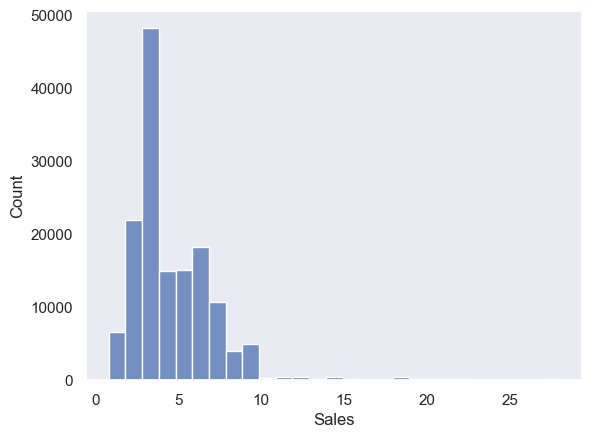

In [56]:
# Basic statistics 
print(coffee[['product_id', 'transaction_qty','unit_price', 'sales']].describe())

# Histogram
h = coffee['sales']
h=[i for i in h if i<30]

ax1 = sns.histplot(data=h, binwidth=1)
ax1.set(xlabel='Sales')

## Outliers in total sales. 
# Calculate interquartile range 
Iqr = sqldf('''
    WITH ranked_data AS (
        SELECT
            sales,
            ROW_NUMBER() OVER (ORDER BY sales) AS row_num,
            COUNT(*) OVER () AS total_count
        FROM coffee
    ),
    quartiles AS (
        SELECT
            MAX(CASE WHEN row_num = ROUND(0.25 * total_count) THEN sales END) AS q1,
            MAX(CASE WHEN row_num = ROUND(0.75 * total_count) THEN sales END) AS q3
        FROM ranked_data
    )
    SELECT
        q1 AS Q1, q3 AS Q3, q3 - q1 AS IQR
    FROM quartiles;
    ''')

# Calcualte Outliers 
Outliers = sqldf('''      
    SELECT *
      FROM coffee, Iqr
      WHERE coffee.sales >= Q3 + 1.5 * Iqr.IQR OR coffee.sales <= Q1 - 1.5 * Iqr.IQR;
''')

print('Number Outliers: ' + str(Outliers.shape[0]))
print('Portion of outliers in dataset: ' + str(int(100*Outliers.shape[0]/coffee.shape[0])) + "%")

sqldf('''
    SELECT store_location, COUNT(store_location) AS outliers
      FROM Outliers
      GROUP BY store_location;
      ''')

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Daily Sales')]

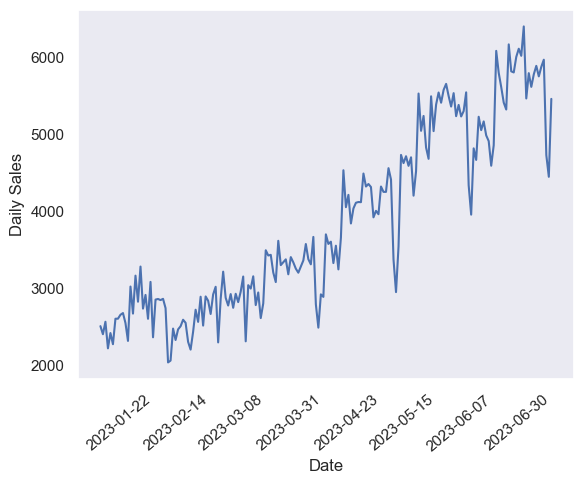

In [57]:
## Time series plot for sales across all stores.
# Select daily sales 
total_sales_time =  sqldf('''
        SELECT transaction_date, SUM(sales) AS 'daily_sales'
        FROM coffee
        GROUP BY transaction_date;
    ''')

# Create line plot
ax2 = sns.lineplot(data = total_sales_time, x = 'transaction_date', y = 'daily_sales')

# Modify plots
ax2.set_xticks([int((total_sales_time.shape[0]*i)/8)-1 for i in range(9)]); # partition x axis into 8 bins
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right"); # rotate x axis
ax2.set(xlabel = 'Date', ylabel = 'Daily Sales')


### Comparison of sales Between Stores


To extract out more information regarding customer sales behavior, we look at sales grouped by store, product type and product. In analyzing each group, we further aggregate the time series into three different time scales; monthly, weekly and hourly to investigate the trend of sales. 

All three store locations have comparable total sales, approximately 230000 USD. 
Again, we see similar means counts and quantiles. We do note that the maximum and standard deviation for "Hell's Kitchen" is quite different to the other two stores. This is likely due to the presence of outliers in "Hell's Kitchen" where the highest sales transaction is 360 USD, compared to the 72 USD and 45 USD recorded in the other stores. To compare the distribution of sales, we plot a violin plot. Due to the presence of outliers, we restrict the plot to values where the sales do not exceed 100 USD. This gives us a clearer view of the distributions for each store in the violin plot.

The results of the F-test indicate that the variation between groups is significant. Therefore, in the rest of this analysis, we will analyse the data by individual stores. 

    Store Location  Total Sales (USD)
0          Astoria          231708.21
1   Hell's Kitchen          236018.62
2  Lower Manhattan          229593.15
       Hell's Kitchen  Lower Manhattan       Astoria
count    50594.000000     47659.000000  50449.000000
mean         4.664953         4.817414      4.592920
std          5.847014         3.284367      2.881086
min          0.800000         0.800000      0.800000
25%          3.000000         3.000000      3.000000
50%          3.750000         3.750000      3.750000
75%          6.000000         6.000000      6.000000
max        360.000000        72.000000     45.000000


[Text(0, 0.5, 'Total Sales (USD)')]

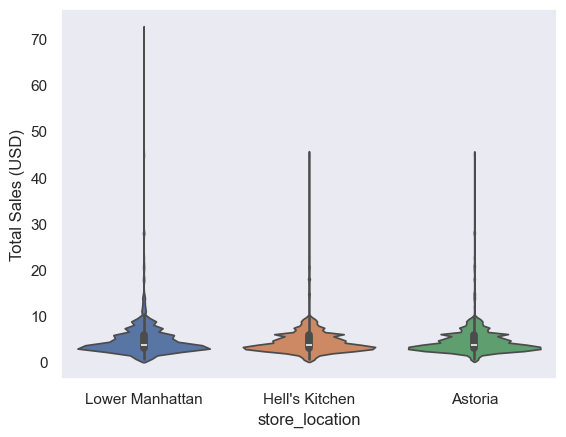

In [58]:
# Calculate total sales for each location 
Tot = sqldf('''
    SELECT store_location AS [Store Location], SUM(sales) AS [Total Sales (USD)]
      FROM coffee
      GROUP BY store_location
      ''')

print(Tot)

# Split sales into store location 
H = coffee.loc[coffee['store_location'] == "Hell's Kitchen"][['sales']]
L = coffee.loc[coffee['store_location'] == "Lower Manhattan"][['sales']]
A = coffee.loc[coffee['store_location'] == "Astoria"][['sales']]

# Show basic statistics for each store
d = {"Hell's Kitchen": H['sales'], "Lower Manhattan": L['sales'], "Astoria": A['sales']}
store_sales = pd.DataFrame(data= d)
print(store_sales.describe())

# Make violin plots for sales for each store ID (location) 
ax = sns.violinplot(
#  Query sales and remove outliers from Hells Kitchen
    data = sqldf('''
      SELECT store_location, sales 
      FROM coffee  
      WHERE sales < 100;
    '''),
    x = 'store_location', y = 'sales', hue = 'store_location'
    )

ax.set(ylabel='Total Sales (USD)')

lambda used in Boxcox transformation: 0.00043198809734495383
F statistic: [28.11352536]
p value: [6.205244e-13]


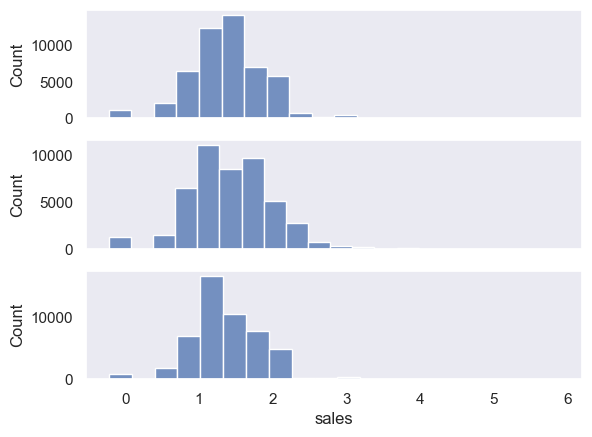

In [59]:
# Copy data
coffee_B = coffee.copy()

# Apply Boxcox tranformation with log likelyhod optimised parameter lambda 
x,l = stats.boxcox(coffee_B['sales'])

# Results of fit
print('lambda used in Boxcox transformation: ' + str(l))
coffee_B['sales'] = x

# Split sales into store location 
H = coffee_B.loc[coffee_B['store_location'] == "Hell's Kitchen"][['sales']]
L = coffee_B.loc[coffee_B['store_location'] == "Lower Manhattan"][['sales']]
A = coffee_B.loc[coffee_B['store_location'] == "Astoria"][['sales']]

# Set up subplots 
fig, axes = plt.subplots(3, 1, sharex=True)

# Plot historgrams
sns.histplot(x = 'sales', ax = axes[0], data = H, binwidth= 0.3, multiple = "dodge")
sns.histplot(x = 'sales', ax = axes[1], data = L, binwidth= 0.3, multiple = "dodge")
sns.histplot(x = 'sales', ax = axes[2], data = A, binwidth= 0.3, multiple = "dodge")

# Anova test 
F, p = stats.f_oneway(A, L, H)

print('F statistic: ' + str(F))
print('p value: '+ str(p))


The next block of code plots the sales trend of each store for the whole data, for an average week, and average day. Here 
- The average weekly sales capturing the 'typical' sales within a week sales is calculated by taking the sum sales for each day of the week and diving this number of 25, the number of weeks in the data set.
- Similarly, the average hourly sales capturing the 'typical' sales in a day is computed by taking the total sales occurring within a given hour and diving the result by the 128, the number of days recorded in the data set. 


Throughout the half year, there does not appear to be a difference in sales performance between the stores. For the week sales, a slightly higher sales is observed 'Hell's Kitchen". A more distinctive pattern can be observed in the hourly time series. We have a peak across all three stores between 8 and 10 AM followed by a flat trend throughout the rest of the day, until a drop in the last hour. Interestingly, this drop is not observed in Astoria. 

The graph is also useful for daily operational planning. For example, there is an anticipated spike in sales in the morning which may warrant more shifts for employees to be assigned to these hours. On the other hand, a dip in sales through the afternoon and evening indicates that fewer shifts need to be assigned to these times. Furthermore, if each store has an estimated operation cost over its opening hours, then the stores can better adjust such costs to ensure that the operational cost does not exceed the sales in each hour. 

/var/folders/5p/jyr0hpzn3md4y89p3c900rx40000gp/T/ipykernel_99624/484973848.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun'])


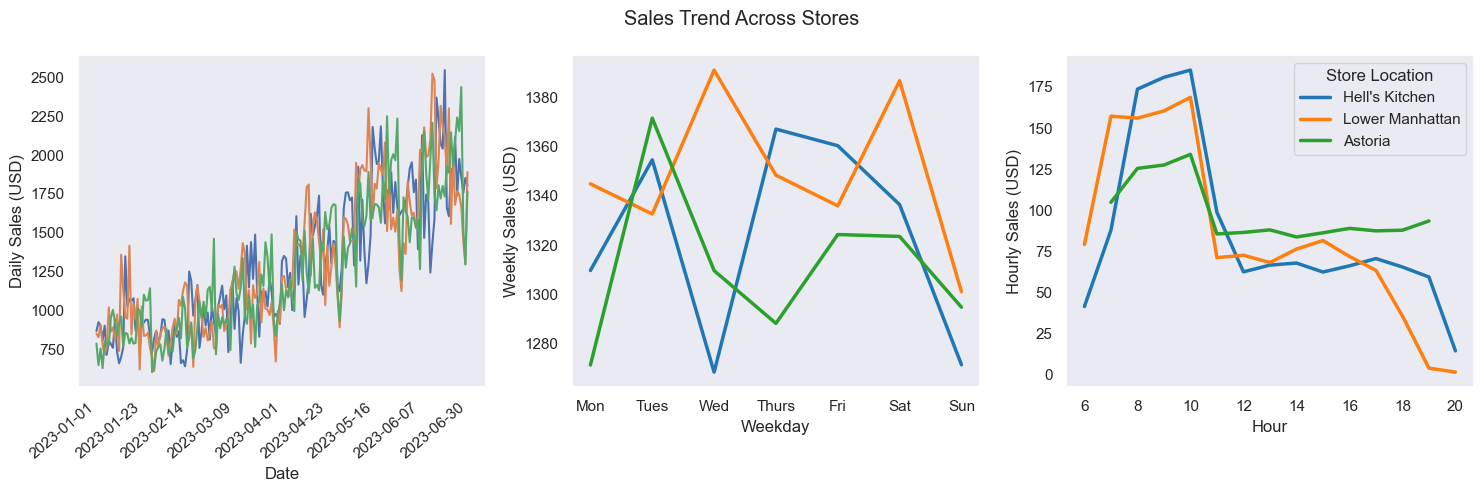

In [60]:
# Data for daily sales
store_sales_time =  sqldf('''
        SELECT transaction_date, SUM(sales) AS 'daily_sales', store_location
        FROM coffee
        GROUP BY transaction_date, store_location;
    ''')

# Data for averge weekly sales
TS_store_weekly = sqldf('''
      SELECT store_location, weekday, SUM(sales)/(25) AS weekly_sales
      FROM (
            SELECT store_location, sales, strftime('%w',transaction_date) AS weekday
            FROM coffee
            )
      GROUP BY weekday, store_location;
      ''')

# Data for average hourly sales
TS_store_hour = sqldf('''
        SELECT store_location, CAST(strftime('%H', transaction_time) AS INT) AS hour, SUM(sales)/181 AS hourly_sales_avg
        FROM coffee 
        GROUP BY hour, store_location
    ''')

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Sales Trend Across Stores')

# Create line plot
sns.lineplot(ax = axs[0], data = store_sales_time, x='transaction_date', y='daily_sales', hue='store_location')
axs[0].set_xticks([int((i*store_sales_time.shape[0]/3)/8-0.5) for i in range(9)]); # set out spacing for x ticks 
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=40, ha="right"); # rotate dates on x axis
axs[0].set(ylabel='Daily Sales (USD)', xlabel='Date')# add labels
axs[0].get_legend().remove()

# Create line plot 
sns.lineplot(ax = axs[1], data = TS_store_weekly, x = 'weekday', y = 'weekly_sales', hue = 'store_location', palette="tab10", linewidth=2.5)
axs[1].set(xlabel='Weekday', ylabel='Weekly Sales (USD)')
axs[1].set_xticklabels(['Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun'])
axs[1].get_legend().remove()

# Create line plot aggregated over propduct type
sns.lineplot(ax = axs[2], data= TS_store_hour, x = 'hour', y = 'hourly_sales_avg', hue = 'store_location', palette="tab10", linewidth=2.5)
axs[2].legend(title='Store Location')
axs[2].set(xlabel='Hour', ylabel='Hourly Sales (USD)')

plt.tight_layout()
plt.show()


### Comparison of sales bewteen product types

We now repeat the above analysis, but with further separation into product types. 

From the stacked bar plot, we observe the following. Products under the Barista Espresso types generate the highest sales. The next three best-selling product types are the Brewed Chai tea, Hot chocolate and Gourmet brewed coffee types, all with similar total sales. There is a substantial gap in total sales between the 4th and 5th ranked product types. 

From a heat map, the highest correlation is between Gourmet brewed coffee and Barista Espresso.

Other highly correlated pairs include:
- Gourmet brewed coffee vs Brewed Chai tea
- Gourmet brewed coffee vs Brewed herbal tea 
- Hot chocolate vs Brewed Chai tea
- Hot chocolate vs Barista Espresso 

Note that there seems to be correlation between similar product types. "

            product_type  total_sales  rank
0       Barista Espresso     91089.90     1
1        Brewed Chai tea     77032.95     2
2          Hot chocolate     72390.50     3
3  Gourmet brewed coffee     70021.10     4


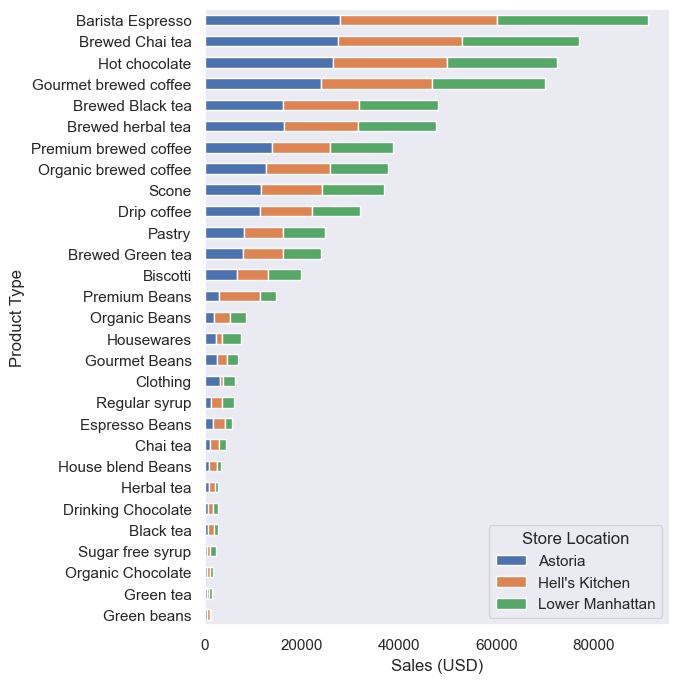

In [61]:
# Query total sales for each product and its rank by total sales
Tot_type = sqldf('''
      SELECT product_type, total_sales, RANK() OVER(ORDER BY total_sales DESC) AS rank
      FROM (
        SELECT product_type, 
                SUM(sales) AS total_sales
        FROM coffee
        GROUP BY product_type
      );
    ''')

# Print first 5 results 
print(Tot_type[0:4])

## Create bar plot, querying highest ranking product types
# Select data
df_wide = sqldf('''
    SELECT coffee.store_location, coffee.product_type, SUM(sales) AS product_sales
    FROM coffee 
    LEFT JOIN Tot_type
        ON coffee.product_type = Tot_type.product_type
    WHERE rank BETWEEN 1 AND 29
    GROUP BY  coffee.store_location, coffee.product_type
    ORDER BY Tot_type.total_sales;
    ''').pivot_table(index = 'product_type', columns='store_location', values='product_sales', sort = False)

# Create plots
ax = df_wide.plot.barh(stacked = True, figsize = (6,8))

# Modify plots
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Sales (USD)', ylabel='Product Type')
ax.legend(title='Store Location')

product_type           product_type     
Gourmet brewed coffee  Barista Espresso     0.900578
                       Brewed Chai tea      0.894260
                       Brewed herbal tea    0.891396
Hot chocolate          Brewed Chai tea      0.882999
                       Barista Espresso     0.882146
dtype: float64

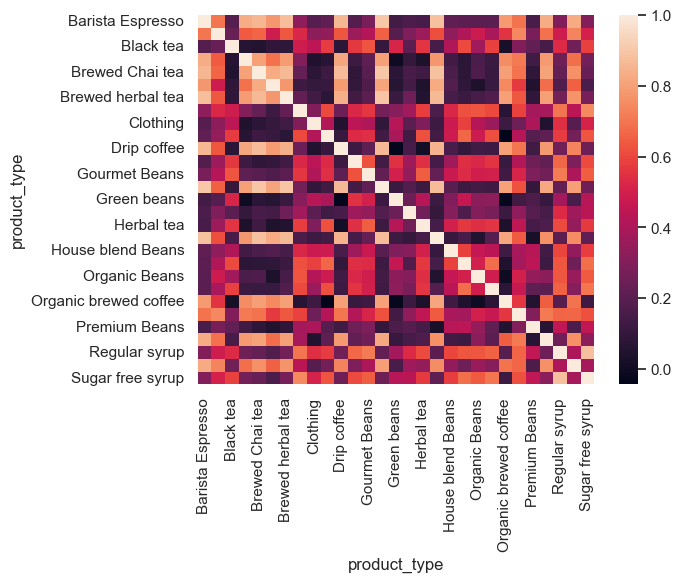

In [62]:
## Create correlation heatmap 
# Query sales, convert to long form, fill NAs with 0, then calcaulate correlation 
corr = sqldf('''
    SELECT transaction_date, product_type, SUM(sales) AS sales
    FROM coffee
    GROUP BY transaction_date, product_type
      ''').pivot(index='transaction_date', columns = 'product_type', values = 'sales').fillna(0).corr()

# Plot heatmap of correlation matrix
sns.heatmap(corr)

# Mask bottom triangle of correlation matrix
corr = pd.DataFrame(data=np.triu(corr, k=1), index = corr.columns, columns=corr.columns)

# Obtain highest correlated pairs of product types
sorted_correlations = corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
sorted_correlations.head()

In the following code, we generate a plot similar to the line plots by store location. 

The spike in sales in the morning can be observed across product types. The sales across an average week and across the entire first half of the year shows a clear distinction in sales performance based on product type. 

/var/folders/5p/jyr0hpzn3md4y89p3c900rx40000gp/T/ipykernel_99624/3867917672.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun'])


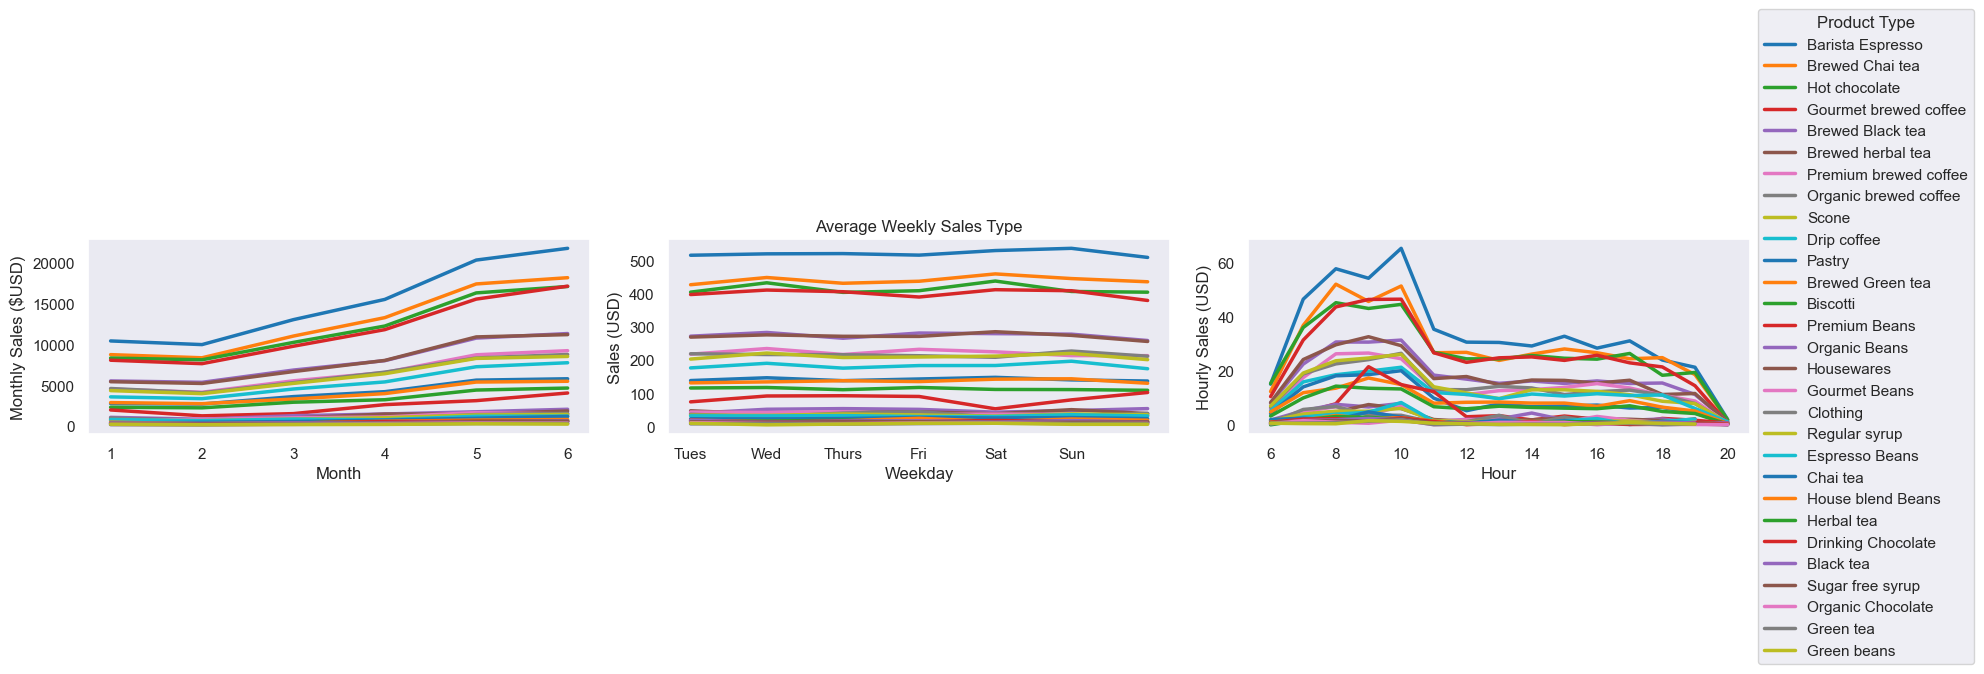

In [63]:
# Yearly variation in total sales for each product type 
TS_type_month = sqldf('''
        SELECT  coffee.product_type, CAST(strftime('%m', transaction_date) AS INT) AS month, SUM(sales) AS monthly_sales
        FROM coffee
        LEFT JOIN Tot_type
          ON coffee.product_type = Tot_type.product_type
        WHERE Tot_type.rank BETWEEN 1 AND 29
        GROUP BY month, coffee.product_type
        ORDER BY Tot_type.rank;
    ''')

# Average weekly sales for the five top selling product types based on total sales

TS_type_week = sqldf('''
        SELECT coffee.product_type, CAST(strftime('%w', transaction_date) AS INT) AS weekday, SUM(sales)/25 AS weekly_sales_avg
        FROM coffee 
        LEFT JOIN Tot_type
          ON coffee.product_type = Tot_type.product_type
        WHERE Tot_type.rank BETWEEN 1 AND 29
        GROUP BY weekday, coffee.product_type
        ORDER BY Tot_type.rank;
      ''')

# Average hourly sales for the five top selling product types based on total sales
TS_type_hour = sqldf('''
        SELECT coffee.product_type, CAST(strftime('%H', transaction_time) AS INT) AS hour, SUM(sales)/181 AS hourly_sales_avg
        FROM coffee 
        LEFT JOIN Tot_type
          ON coffee.product_type = Tot_type.product_type
        WHERE Tot_type.rank BETWEEN 1 AND 29
        GROUP BY hour, coffee.product_type
        ORDER BY Tot_type.rank;
    ''')


# Create subplots
fig, axs = plt.subplots(1,3,figsize = (20,5))

# Create line plot aggregated over propduct type
sns.lineplot(ax = axs[0], data=TS_type_month, x = 'month', y = 'monthly_sales', hue = 'product_type', palette="tab10", linewidth=2.5)
axs[0].set(xlabel='Month', ylabel='Monthly Sales ($USD)')
axs[0].get_legend().remove()


# Create line plot aggregated over propduct type
sns.lineplot(ax = axs[1], data= TS_type_week, x = 'weekday', y = 'weekly_sales_avg', hue = 'product_type', palette="tab10", linewidth=2.5)
axs[1].set(title = 'Average Weekly Sales Type', xlabel='Weekday', ylabel='Sales (USD)')
axs[1].set_xticklabels(['Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun'])
axs[1].get_legend().remove()


# Create line plot aggregated over propduct type
sns.lineplot(ax = axs[2], data= TS_type_hour, x = 'hour', y = 'hourly_sales_avg', hue = 'product_type', palette="tab10", linewidth=2.5)
axs[2].set(xlabel='Hour', ylabel='Hourly Sales (USD)')
axs[2].legend(title='Product Type')
sns.move_legend(axs[2], "center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()



### Comparison of sales between products

Finally, we refine our analysis at the level of products (in the data, we call this 'product detail'). There are 80 products in total, which we rank based on total sales.

To see the sales across store location, we create a stacked barplot of total sales for each product and stacked based on store location.  

In [64]:
# Query total sales by product detail
Tot_prod = sqldf('''
      SELECT product_detail, total_sales, RANK() OVER(ORDER BY total_sales DESC) AS rank
      FROM (
        SELECT product_detail, 
                SUM(sales) AS total_sales
        FROM coffee
        GROUP BY product_detail
      );
    ''')

# Ranking 
print(Tot_prod.head())

                 product_detail  total_sales  rank
0  Sustainably Grown Organic Lg     21151.75     1
1             Dark chocolate Lg     20988.00     2
2                      Latte Rg     19074.00     3
3                 Cappuccino Lg     17607.75     4
4       Morning Sunrise Chai Lg     17368.00     5


[Text(0.5, 0, 'Sales (USD)'), Text(0, 0.5, 'Product')]

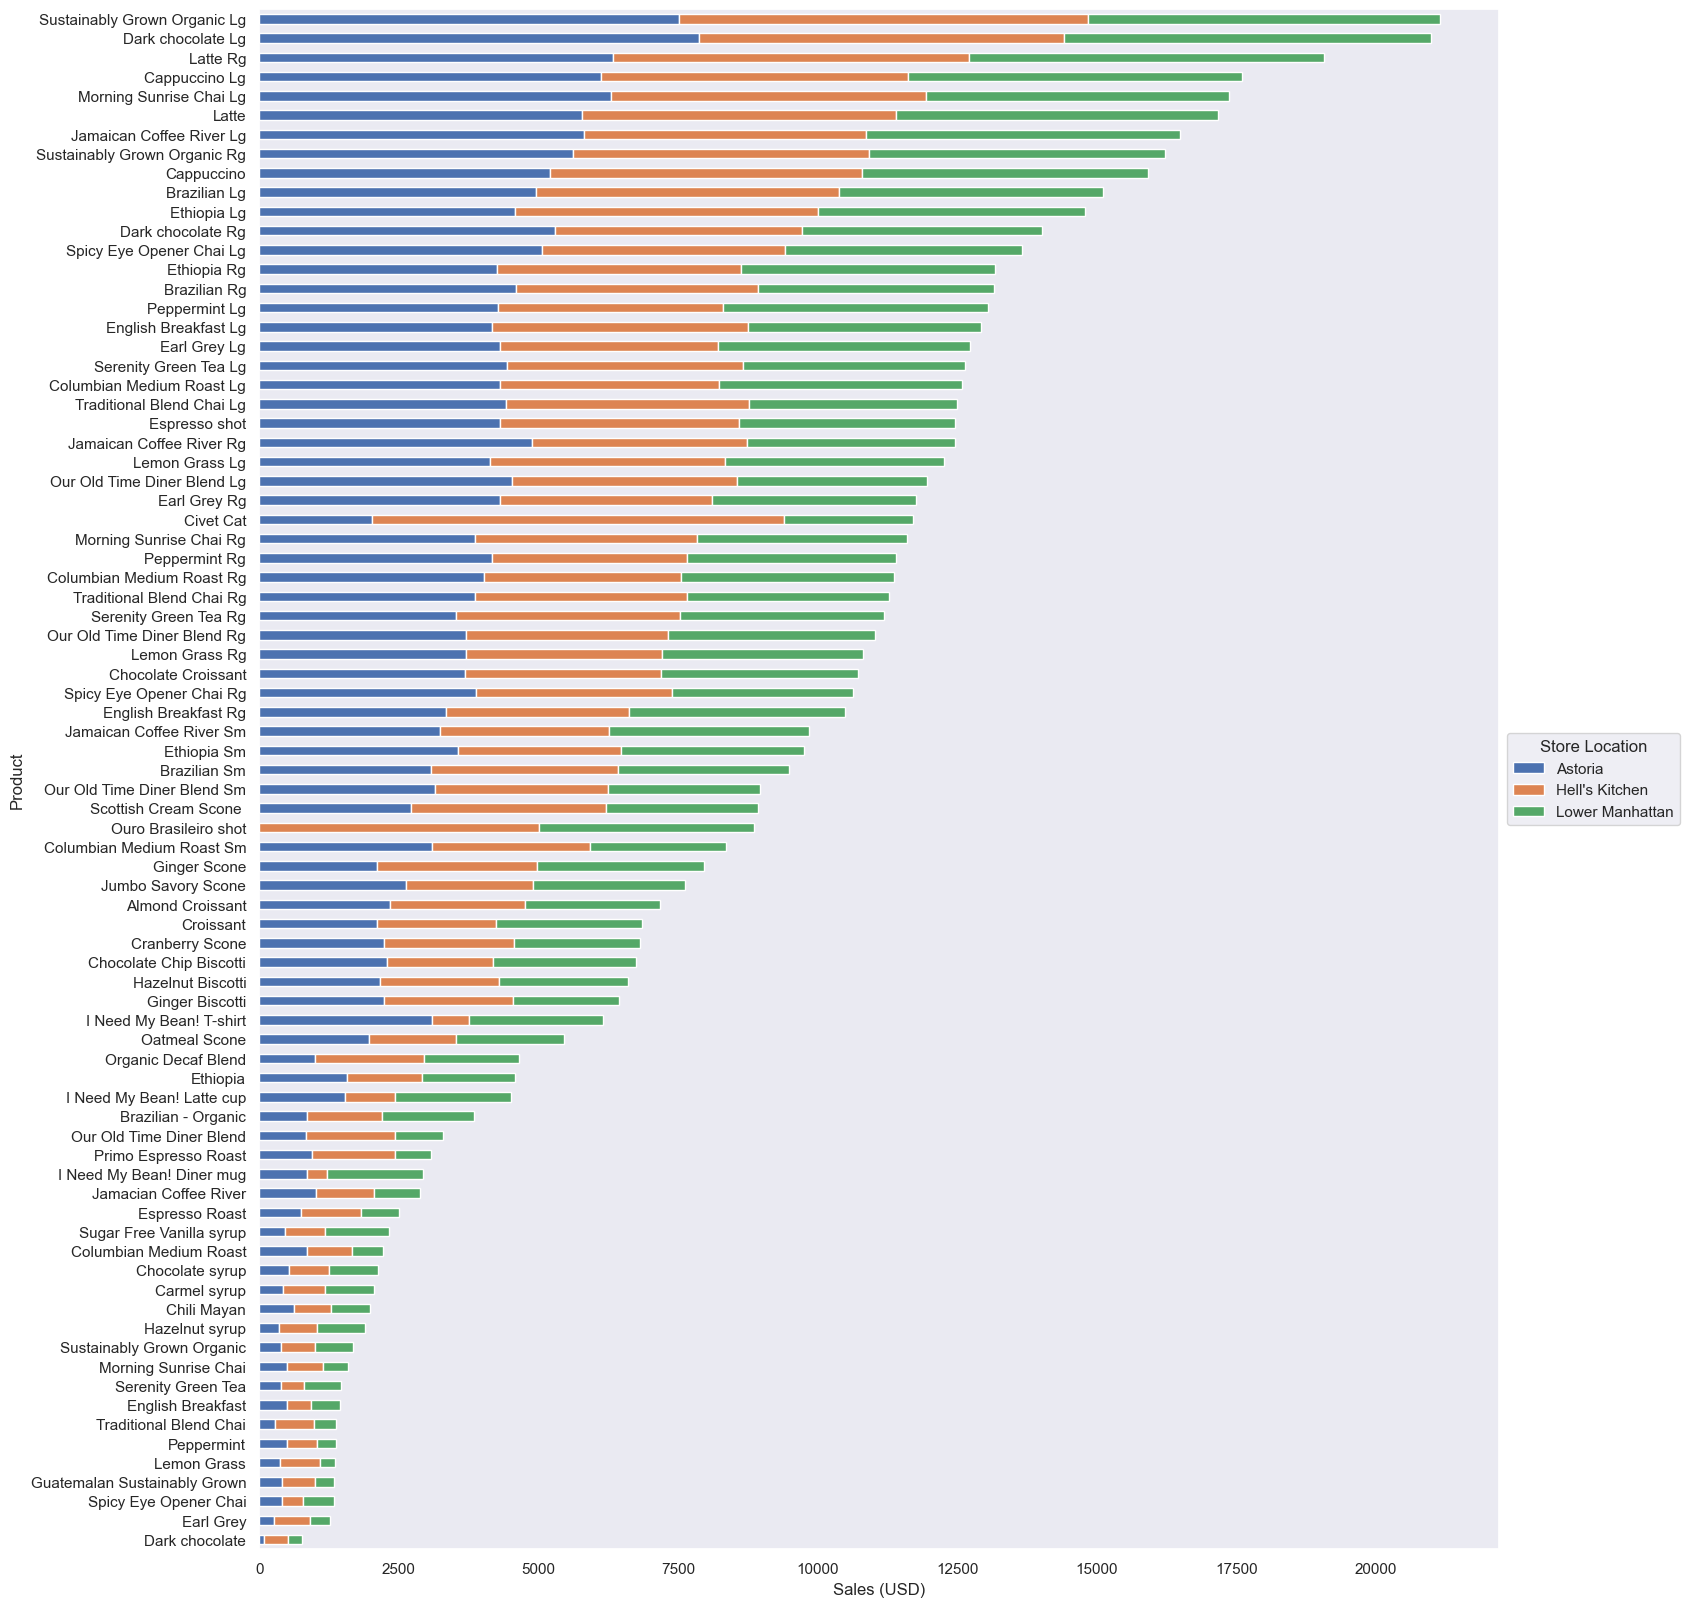

In [65]:
# Create bar plot
df_wide = sqldf('''
      SELECT coffee.store_location, coffee.product_detail, SUM(sales) AS product_sales
      FROM coffee 
      LEFT JOIN Tot_prod
          ON coffee.product_detail = Tot_prod.product_detail
      WHERE rank BETWEEN 1 AND 80
      GROUP BY coffee.store_location, coffee.product_detail
      ORDER BY Tot_prod.rank DESC;
    ''').pivot_table(index='product_detail', columns='store_location', values='product_sales', sort=False)

ax = df_wide.plot.barh(stacked=True,figsize = (16, 20))

# Modify plots
ax.legend(title = 'Store Location')
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel='Sales (USD)', ylabel='Product')

product_detail            product_detail         
Sugar Free Vanilla syrup  Hazelnut syrup             0.812859
                          Chocolate syrup            0.807478
                          Carmel syrup               0.805481
Hazelnut syrup            Carmel syrup               0.765885
                          Chocolate syrup            0.763196
                                                       ...   
Brazilian - Organic       Cappuccino Lg              0.000000
                          Carmel syrup               0.000000
                          Chili Mayan                0.000000
                          Chocolate Chip Biscotti    0.000000
                          Chocolate Croissant        0.000000
Length: 6400, dtype: float64

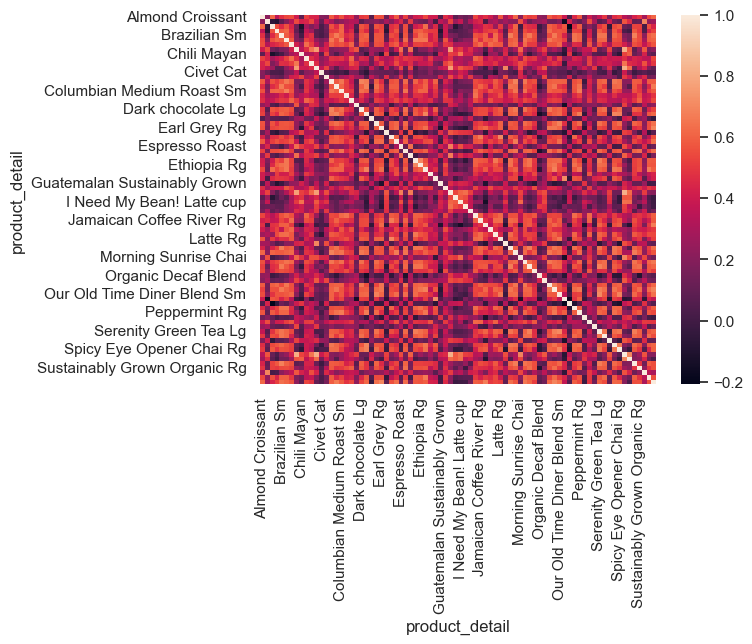

In [66]:
# Query sales, convert to long form, fill NAs with 0, then calcaulate correlation 
corr = sqldf('''
    SELECT transaction_date, product_detail, SUM(sales) AS sales
    FROM coffee
    GROUP BY transaction_date, product_detail
      ''').pivot(index='transaction_date', columns = 'product_detail', values = 'sales').fillna(0).corr()

# Plot heatmap of correaltion matrix
sns.heatmap(corr)

# Mask bottom triangle of correaltion matrix
corr = pd.DataFrame(data=np.triu(corr, k=1), index = corr.columns, columns=corr.columns)

# Obtain highest correlated 
corr.abs().unstack().sort_values(kind="quicksort", ascending=False)

Turning now to the monthly variation for each product type. To avoid a cluttered graph, we plot the sales for every 5 rankings.

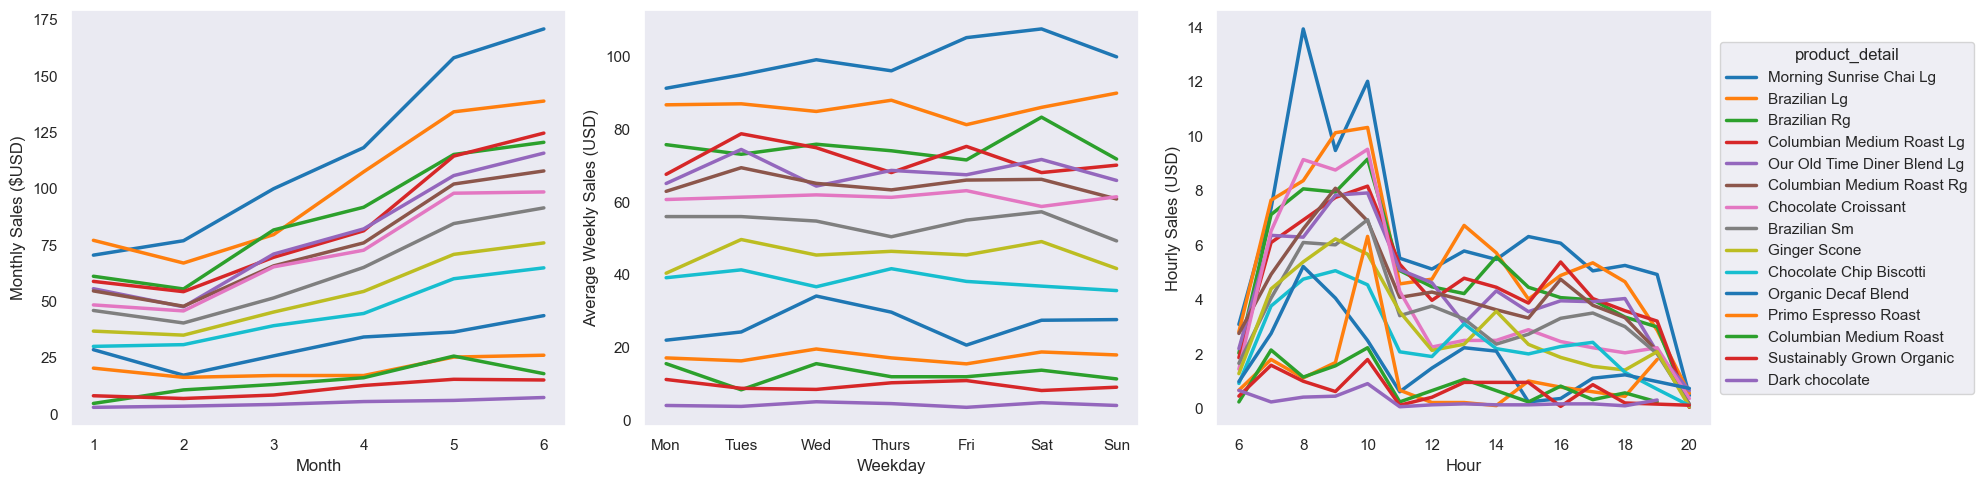

In [69]:
# Total sales  for the five top selling product types based on total sales
TS_prod_month = sqldf('''
        SELECT  coffee.product_detail, CAST(strftime('%m', transaction_date) AS INT) AS month, SUM(sales)/25 AS monthly_sales
        FROM coffee
        LEFT JOIN Tot_prod
          ON coffee.product_detail = Tot_prod.product_detail
        WHERE Tot_prod.rank BETWEEN 1 AND 80 AND MOD(Tot_prod.rank, 5) = 0 
        GROUP BY month, coffee.product_detail
        ORDER BY Tot_prod.rank;
    ''')


# Average daily sales for the five top selling product types based on total sales
TS_prod_week = sqldf('''
        SELECT coffee.product_detail, CAST(strftime('%w', transaction_date) AS INT) AS weekday, SUM(sales)/25 AS weekly_sales_avg
        FROM coffee 
        LEFT JOIN Tot_prod
          ON coffee.product_detail = Tot_prod.product_detail
        WHERE Tot_prod.rank BETWEEN 1 AND 80 AND MOD(Tot_prod.rank, 5) = 0
        GROUP BY weekday, coffee.product_detail
        ORDER BY Tot_prod.rank;
      ''')

# Average hourly sales for the five top selling product types based on total sales
TS_prod_hour = sqldf('''
        SELECT coffee.product_detail, CAST(strftime('%H', transaction_time) AS INT) AS hour, SUM(sales)/181 AS hourly_sales_avg
        FROM coffee 
        LEFT JOIN Tot_prod
          ON coffee.product_detail = Tot_prod.product_detail
        WHERE Tot_prod.rank BETWEEN 1 AND 80 AND MOD(Tot_prod.rank, 5) = 0
        GROUP BY hour, coffee.product_detail
        ORDER BY Tot_prod.rank;
    ''')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize = (20,5))

# Create line plot 
sns.lineplot(ax = axs[0], data=TS_prod_month, x = 'month', y = 'monthly_sales', hue = 'product_detail', palette="tab10", linewidth=2.5)
axs[0].set(xlabel='Month', ylabel='Monthly Sales ($USD)')
axs[0].get_legend().remove()


# Create line plot 
sns.lineplot(ax=axs[1], data=TS_prod_week , x = 'weekday', y = 'weekly_sales_avg', hue = 'product_detail', palette="tab10", linewidth=2.5)
axs[1].set(xlabel='Weekday', ylabel='Average Weekly Sales (USD)')
axs[1].set_xticks(np.delete(axs[1].get_xticks(),[0,-1]))
axs[1].set_xticklabels(['Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat','Sun'])
axs[1].get_legend().remove()


# Create line plot aggregated over propduct type
sns.lineplot(ax=axs[2], data= TS_prod_hour, x = 'hour', y = 'hourly_sales_avg', hue = 'product_detail', palette="tab10", linewidth=2.5)
axs[2].set(xlabel='Hour', ylabel='Hourly Sales (USD)')

sns.move_legend(axs[2], "center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout() 
plt.show()
